In [1]:
# USAGE
# python text_detection.py --image images/lebron_james.jpg --east frozen_east_text_detection.pb

# import the necessary packages
from imutils.object_detection import non_max_suppression
import numpy as np
# import argparse
import time
import cv2
# image filtering imports
from PIL import Image

In [11]:
cv2.__version__

'4.1.0'

# Detecting Text Area with EAST Text Detector

In [6]:
# construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--image", type=str,
# 	help="path to input image")
# ap.add_argument("-east", "--east", type=str,
# 	help="path to input EAST text detector")
# ap.add_argument("-c", "--min-confidence", type=float, default=0.5,
# 	help="minimum probability required to inspect a region")
# ap.add_argument("-w", "--width", type=int, default=320,
# 	help="resized image width (should be multiple of 32)")
# ap.add_argument("-e", "--height", type=int, default=320,
# 	help="resized image height (should be multiple of 32)")
# args = vars(ap.parse_args())

In [5]:
# load the input image and grab the image dimensions

# image = cv2.imread('/home/ec2-user/SageMaker/OCR_rxid/images/car_wash.png')
image = cv2.imread('/home/ec2-user/SageMaker/train/cap.10.jpg')
orig = image.copy()
(H, W) = image.shape[:2]

In [6]:
pwd

'/home/ec2-user/SageMaker'

In [7]:
# set the new width and height and then determine the ratio in change
# for both the width and height
# (newW, newH) = (args["width"], args["height"])
rW = W / float(320)
rH = H / float(320)

# resize the image and grab the new image dimensions
image = cv2.resize(image, (320, 320))
(H, W) = image.shape[:2]

In [8]:
# define the two output layer names for the EAST detector model that
# we are interested -- the first is the output probabilities and the
# second can be used to derive the bounding box coordinates of text
layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]

# load the pre-trained EAST text detector
print("[INFO] loading EAST text detector...")
net = cv2.dnn.readNet('/home/ec2-user/SageMaker/frozen_east_text_detection.pb')

[INFO] loading EAST text detector...


In [9]:
# construct a blob from the image and then perform a forward pass of
# the model to obtain the two output layer sets
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
	(123.68, 116.78, 103.94), swapRB=True, crop=False)
start = time.time()
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
end = time.time()

# show timing information on text prediction
print("[INFO] text detection took {:.6f} seconds".format(end - start))

[INFO] text detection took 0.198600 seconds


In [10]:
# grab the number of rows and columns from the scores volume, then
# initialize our set of bounding box rectangles and corresponding
# confidence scores
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []

# loop over the number of rows
for y in range(0, numRows):
	# extract the scores (probabilities), followed by the geometrical
	# data used to derive potential bounding box coordinates that
	# surround text
	scoresData = scores[0, 0, y]
	xData0 = geometry[0, 0, y]
	xData1 = geometry[0, 1, y]
	xData2 = geometry[0, 2, y]
	xData3 = geometry[0, 3, y]
	anglesData = geometry[0, 4, y]

	# loop over the number of columns
	for x in range(0, numCols):
		# if our score does not have sufficient probability, ignore it
		if scoresData[x] < 0.5:
			continue

		# compute the offset factor as our resulting feature maps will
		# be 4x smaller than the input image
		(offsetX, offsetY) = (x * 4.0, y * 4.0)

		# extract the rotation angle for the prediction and then
		# compute the sin and cosine
		angle = anglesData[x]
		cos = np.cos(angle)
		sin = np.sin(angle)

		# use the geometry volume to derive the width and height of
		# the bounding box
		h = xData0[x] + xData2[x]
		w = xData1[x] + xData3[x]

		# compute both the starting and ending (x, y)-coordinates for
		# the text prediction bounding box
		endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
		endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
		startX = int(endX - w)
		startY = int(endY - h)

		# add the bounding box coordinates and probability score to
		# our respective lists
		rects.append((startX, startY, endX, endY))
		confidences.append(scoresData[x])

# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
boxes = non_max_suppression(np.array(rects), probs=confidences)

# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
	# scale the bounding box coordinates based on the respective
	# ratios
	startX = int(startX * rW)
	startY = int(startY * rH)
	endX = int(endX * rW)
	endY = int(endY * rH)

	# draw the bounding box on the image
	cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)

In [12]:
# show the output image
cv2.imwrite('/home/ec2-user/SageMaker/detected_images/DETECT_cap.10.jpg', orig)

True

In [13]:
import imageio
import matplotlib.pyplot as plt
detected_img = imageio.imread('/home/ec2-user/SageMaker/detected_images/DETECT_cap.10.jpg')

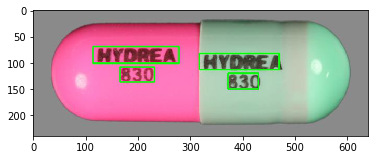

In [14]:
plt.imshow(detected_img);

# OpenCV OCR & Text Recognition with Tesseract

Tutorial: https://www.pyimagesearch.com/2018/08/20/opencv-text-detection-east-text-detector/

In [2]:
# import the necessary packages

# for non-maxima suppression as OpenCV’s NMSBoxes function 
# doesn’t seem to be working with the Python API
from imutils.object_detection import non_max_suppression
import numpy as np
import pytesseract
import argparse # included with Python and handles command line arguments
import cv2

import imageio
import matplotlib.pyplot as plt

### `decode_predictions`  function

In [3]:
def decode_predictions(scores, geometry):
	# grab the number of rows and columns from the scores volume, then
	# initialize our set of bounding box rectangles and corresponding
	# confidence scores
	(numRows, numCols) = scores.shape[2:4]
	rects = []
	confidences = []

	# loop over the number of rows
	for y in range(0, numRows):
		# extract the scores (probabilities), followed by the
		# geometrical data used to derive potential bounding box
		# coordinates that surround text
		scoresData = scores[0, 0, y]
		xData0 = geometry[0, 0, y]
		xData1 = geometry[0, 1, y]
		xData2 = geometry[0, 2, y]
		xData3 = geometry[0, 3, y]
		anglesData = geometry[0, 4, y]

		# loop over the number of columns
		for x in range(0, numCols):
			# if our score does not have sufficient probability,
			# ignore it
			if scoresData[x] < 0.5:
				continue

			# compute the offset factor as our resulting feature
			# maps will be 4x smaller than the input image
			(offsetX, offsetY) = (x * 4.0, y * 4.0)

			# extract the rotation angle for the prediction and
			# then compute the sin and cosine
			angle = anglesData[x]
			cos = np.cos(angle)
			sin = np.sin(angle)

			# use the geometry volume to derive the width and height
			# of the bounding box
			h = xData0[x] + xData2[x]
			w = xData1[x] + xData3[x]

			# compute both the starting and ending (x, y)-coordinates
			# for the text prediction bounding box
			endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
			endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
			startX = int(endX - w)
			startY = int(endY - h)

			# add the bounding box coordinates and probability score
			# to our respective lists
			rects.append((startX, startY, endX, endY))
			confidences.append(scoresData[x])

	# return a tuple of the bounding boxes and associated confidences
	return (rects, confidences)

### Load the input image & Grab the image dimensions

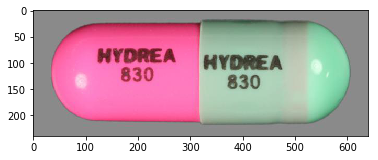

In [10]:
import imageio
import matplotlib.pyplot as plt
img = imageio.imread('/home/ec2-user/SageMaker/train/cap.10.jpg')
plt.imshow(img);

### Working with the EAST text detector

In [4]:
# load the input image and grab the image dimensions
image = cv2.imread('/home/ec2-user/SageMaker/train/cap.10.jpg')
orig = image.copy()
(origH, origW) = image.shape[:2]
 
# set the new width and height and then determine the ratio in change
# for both the width and height
(newW, newH) = (320, 320)
rW = origW / float(newW)
rH = origH / float(newH)
 
# resize the image and grab the new image dimensions
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

In [5]:
# define the two output layer names for the EAST detector model that
# we are interested in -- the first is the output probabilities and the
# second can be used to derive the bounding box coordinates of text
layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]
 
# load the pre-trained EAST text detector
print("Loading EAST text detector...")
net = cv2.dnn.readNet('/home/ec2-user/SageMaker/frozen_east_text_detection.pb')

Loading EAST text detector...


### Build two output layer sets, Decode the predictions & Apply non-maxima suppression
(OpenCV `3.4.2` at a minimum to have the `cv2.dnn.readNet` implementation)

In [6]:
# construct a blob from the image and then perform a forward pass of
# the model to obtain the two output layer sets
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
	(123.68, 116.78, 103.94), swapRB=True, crop=False)
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
 
# decode the predictions, then  apply non-maxima suppression to
# suppress weak, overlapping bounding boxes
(rects, confidences) = decode_predictions(scores, geometry)
boxes = non_max_suppression(np.array(rects), probs=confidences)

### Obtaning Bounding Boxes around text

In [7]:
# initialize the list of results
results = []
 
# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
	# scale the bounding box coordinates based on the respective
	# ratios
	startX = int(startX * rW)
	startY = int(startY * rH)
	endX = int(endX * rW)
	endY = int(endY * rH)
 
	# in order to obtain a better OCR of the text we can potentially
	# apply a bit of padding surrounding the bounding box -- here we
	# are computing the deltas in both the x and y directions
	dX = int((endX - startX) * 0.08)
	dY = int((endY - startY) * 0.08)
 
	# apply padding to each side of the bounding box, respectively
	startX = max(0, startX - dX)
	startY = max(0, startY - dY)
	endX = min(origW, endX + (dX * 2))
	endY = min(origH, endY + (dY * 2))
 
	# extract the actual padded ROI
	roi = orig[startY:endY, startX:endX]
    
    # in order to apply Tesseract v4 to OCR text we must supply
	# (1) a language, (2) an OEM flag of 4, indicating that the we
	# wish to use the LSTM neural net model for OCR, and finally
	# (3) an OEM value, in this case, 7 which implies that we are
	# treating the ROI as a single line of text
	config = ("-l eng --oem 1 --psm 7")
	text = pytesseract.image_to_string(roi, config=config)
 
	# add the bounding box coordinates and OCR'd text to the list
	# of results
	results.append(((startX, startY, endX, endY), text))

In [8]:
# sort the results bounding box coordinates from top to bottom
results = sorted(results, key=lambda r:r[0][1])
 
# loop over the results
for ((startX, startY, endX, endY), text) in results:
	# display the text OCR'd by Tesseract
	print("OCR TEXT")
	print("========")
	print("{}\n".format(text))
 
	# strip out non-ASCII text so we can draw the text on the image
	# using OpenCV, then draw the text and a bounding box surrounding
	# the text region of the input image
# 	text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
# 	output = orig.copy()
# 	cv2.rectangle(output, (startX, startY), (endX, endY),
# 		(0, 0, 255), 2)
# 	cv2.putText(output, text, (startX, startY - 20),
# 		cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3)

OCR TEXT
HYDREA

OCR TEXT
HYDE A

OCR TEXT
830

OCR TEXT
830



# Testing Image Filters to Improve OCR Results

In [14]:
# Filter to increase image contrast
def add_contrast(image_path):

    #-----Reading the image-----------------------------------------------------
    img = cv2.imread(image_path)

    #-----Converting image to LAB Color model----------------------------------- 
    lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    #-----Splitting the LAB image to different channels-------------------------
    l, a, b = cv2.split(lab)

    #-----Applying CLAHE to L-channel-------------------------------------------
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)

    #-----Merge the CLAHE enhanced L-channel with the a and b channel-----------
    limg = cv2.merge((cl,a,b))

    #-----Converting image from LAB Color model to RGB model--------------------
    image_contrast = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    
    return image_contrast

In [18]:
# Applying image contrast to our image
filtered_img = add_contrast('/home/ec2-user/SageMaker/train/rnd.8.jpg')

# Saving image locally
temp_img = "contrast_img.jpg"
cv2.imwrite(temp_img, filtered_img)
# imageFile2 = '/home/ec2-user/SageMaker/contrast/' + temp_img

True

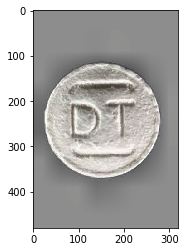

In [22]:
img = imageio.imread('/home/ec2-user/SageMaker/contrast_img.jpg')
plt.imshow(img);

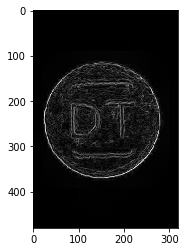

In [39]:
from skimage.filters import roberts, sobel, scharr, prewitt
from skimage.exposure import rescale_intensity
from skimage import color

img_gray = rescale_intensity(color.rgb2gray(img))
img_scharr = scharr(img_gray)
plt.imshow(img_scharr, cmap=plt.cm.gray)

# edge_sobel = sobel(img)
# plt.imshow(edge_sobel, cmap=plt.cm.gray)

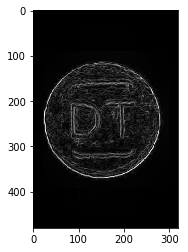

In [42]:
edge_prewitt = prewitt(img_gray)
plt.imshow(edge_prewitt, cmap=plt.cm.gray)

In [ ]:
# Saving image locally
temp_img = "contrast2_img.jpg"
cv2.imwrite(temp_img, filtered_img)